In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import dask.dataframe as dd

In [2]:
# Define path
path = r'C:\Users\Lukman\OneDrive\Documents\FEMINA CF\Data Immerssion\Achievement4\Instacart Basket Analysis'

In [5]:
# Import data
ords_prods_activecust = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_activecustomers.pkl'))

In [6]:
# Initialize the 'profile' column with 'Other'
ords_prods_activecust['profile'] = 'Other'

# Assign 'Single Adult' profile
ords_prods_activecust.loc[(ords_prods_activecust['age'] <= 35) & (ords_prods_activecust['income'] > 70000) & (ords_prods_activecust['n_dependants'] == 0), 'profile'] = 'Single Adult'

# Assign 'Young Parent' profile
ords_prods_activecust.loc[(ords_prods_activecust['age'] <= 35) & (ords_prods_activecust['income'] <= 70000) & (ords_prods_activecust['n_dependants'] > 0), 'profile'] = 'Young Parent'

# Assign 'Established Adult' profile
ords_prods_activecust.loc[(ords_prods_activecust['age'] >= 36) & (ords_prods_activecust['age'] <= 55) & (ords_prods_activecust['income'] > 40000), 'profile'] = 'Established Adult'

# Refine 'Established Adult' based on shopping patterns
ords_prods_activecust.loc[(ords_prods_activecust['age'] >= 36) & (ords_prods_activecust['age'] <= 55) & (ords_prods_activecust['income'] > 40000) & (ords_prods_activecust['orders_day_of_week'].isin([5, 6])), 'profile'] = 'Weekend Shopper - Established Adult'

# Assign 'Senior' profile
ords_prods_activecust.loc[ords_prods_activecust['age'] > 55, 'profile'] = 'Senior'

# Refine 'Senior' based on shopping patterns
ords_prods_activecust.loc[(ords_prods_activecust['age'] > 55) & (ords_prods_activecust['order_hour_of_day'] < 12), 'profile'] = 'Morning Senior'

# Assign 'Budget Shopper' profile
ords_prods_activecust.loc[ords_prods_activecust['income'] <= 40000, 'profile'] = 'Budget Shopper'


# Display the first few rows to verify the new column
ords_prods_activecust.head()


,product_id,product_name,aisle_id,department_id,prices,order_id,user_id,order_number,orders_day_of_week,order_hour_of_day,...,state,age,date_joined,n_dependants,marital_status,income,_merge,Region,exclusion_flag,profile
0,1,Chocolate Sandwich Cookies,61,19,5.800781,3139998,138,28,6,11,...,Minnesota,81,8/1/2019,1,married,49620,both,Midwest,Keep,Morning Senior
1,1,Chocolate Sandwich Cookies,61,19,5.800781,1977647,138,30,6,17,...,Minnesota,81,8/1/2019,1,married,49620,both,Midwest,Keep,Senior
2,1,Chocolate Sandwich Cookies,61,19,5.800781,389851,709,2,0,21,...,Vermont,66,6/16/2018,2,married,158302,both,Northeast,Keep,Senior
3,196,Soda,77,7,9.000000,147387,709,4,0,21,...,Vermont,66,6/16/2018,2,married,158302,both,Northeast,Keep,Senior
4,196,Soda,77,7,9.000000,2322397,709,5,1,21,...,Vermont,66,6/16/2018,2,married,158302,both,Northeast,Keep,Senior


In [7]:
# Get names of each department back into the data
df_dep = pd.read_csv(os.path.join(path, '02 Data', 'Original Data', 'departments.csv'))

In [8]:
# Transpose:
df_dep_t = df_dep.T

In [9]:
# Create index
df_dep_t.reset_index(inplace = True)

In [10]:
# Copy row 0 into variable
new_header = df_dep_t.iloc[0]

In [11]:
# Remove row 0
df_dep_t = df_dep_t[1:]

In [12]:
# Assign header row
df_dep_t.columns = new_header

In [13]:
# Ensure department_id is int8 to merge
df_dep_t['department_id'] = df_dep_t['department_id'].astype('int8')

### Merge with dept data

In [14]:
#Merge data
chunk_size = 100000
result = []

for start in range(0, len(ords_prods_activecust), chunk_size):
    end = start + chunk_size
    chunk = ords_prods_activecust[start:end]
    merged_chunk = chunk.merge(df_dep_t, on='department_id', indicator='merge1')
    result.append(merged_chunk)


full_data = pd.concat(result, ignore_index=True)

In [15]:
profile_region_crosstab = pd.crosstab(full_data['profile'], full_data['Region'])
print(profile_region_crosstab)

Region                               Midwest  Northeast    South     West
profile                                                                  
Budget Shopper                        373583     283124   552104   403214
Established Adult                    1610693    1165735  2223152  1740727
Morning Senior                        983499     760167  1414249  1083485
Other                                 939382     755437  1415585  1050816
Senior                               1816334    1378379  2556989  1998339
Single Adult                          246829     190607   356483   242263
Weekend Shopper - Established Adult   606398     431846   822134   639834
Young Parent                          684795     499390   970443   768549


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

### Profile vs Region

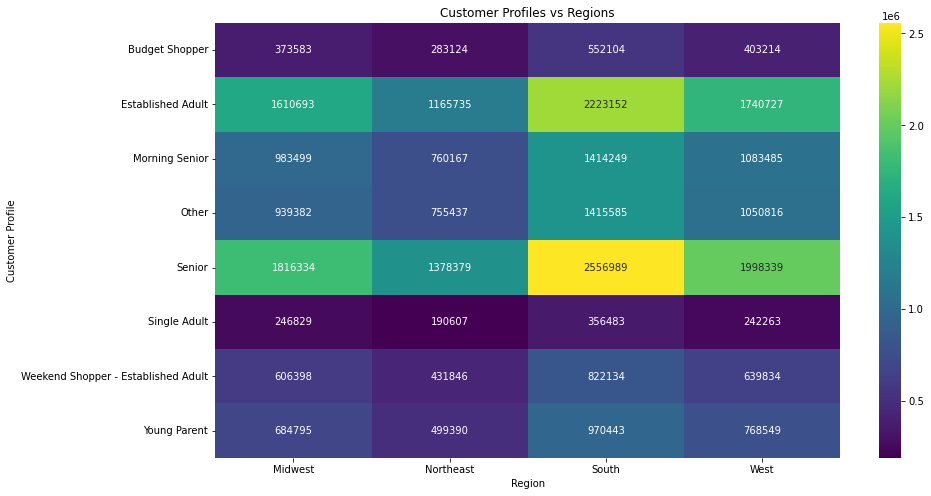

In [18]:
# Plotting Profile vs Region
plt.figure(figsize=(14, 8))
sns.heatmap(profile_region_crosstab, annot=True, fmt='d', cmap='viridis')
plt.title('Customer Profiles vs Regions')
plt.xlabel('Region')
plt.ylabel('Customer Profile')

plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'customer_profiles_vs_region.png'), bbox_inches = 'tight')
plt.show()

### Profile vs Department

In [19]:
profile_department_crosstab = pd.crosstab(full_data['profile'], full_data['department'])
print(profile_department_crosstab)

department                           alcohol  babies  bakery  beverages  \
profile                                                                   
Budget Shopper                          8718   12547   49409     191662   
Established Adult                      29334   96611  245067     550121   
Morning Senior                         16421   59633  154907     357455   
Other                                  21166   55678  154087     324594   
Senior                                 38094   98963  281980     626184   
Single Adult                            4983   15281   38435      82609   
Weekend Shopper - Established Adult    12896   33962   91392     202133   
Young Parent                           13015   37717  105551     237143   

department                           breakfast  bulk  canned goods  \
profile                                                              
Budget Shopper                           46066  2247         34946   
Established Adult                      

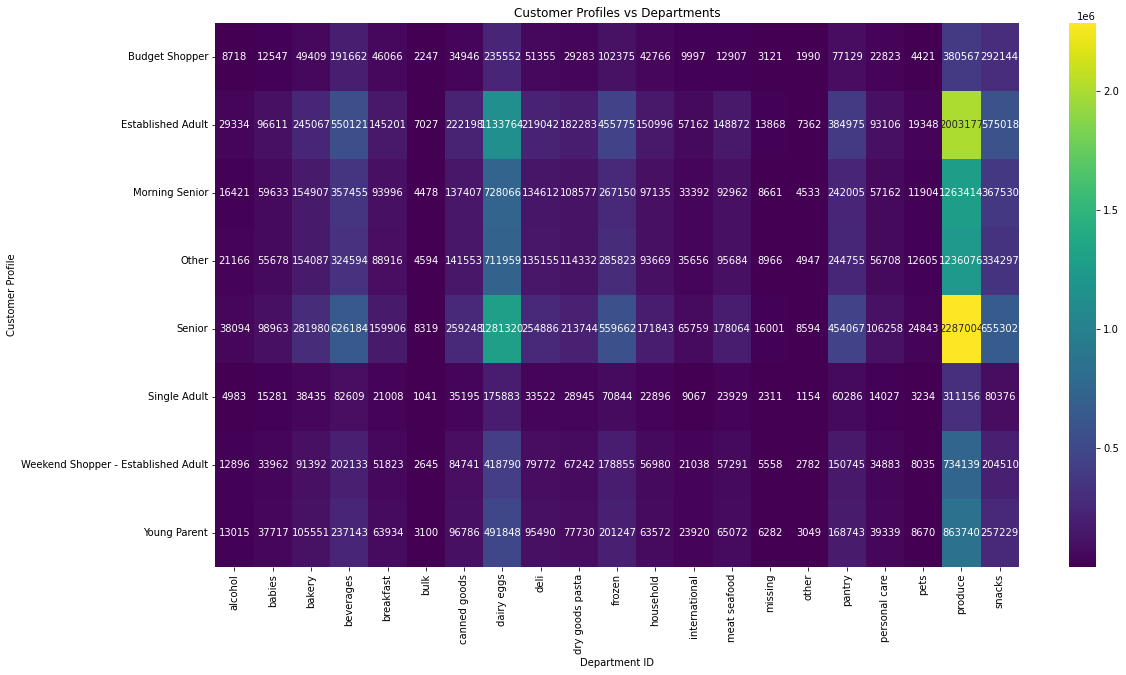

In [20]:
# Plotting Profile vs Department
plt.figure(figsize=(18, 10))
sns.heatmap(profile_department_crosstab, annot=True, fmt='d', cmap='viridis')
plt.title('Customer Profiles vs Departments')
plt.xlabel('Department ID')
plt.ylabel('Customer Profile')

plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'customer_profile_vs_department.png'), bbox_inches = 'tight')
plt.show()

## 10.  Export your final data set

In [21]:
full_data.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'instacart_full_data.pkl'))

### Further Analysis

Number of orders by day of week

In [22]:
full_data.columns

Index(['product_id', 'product_name', 'aisle_id', 'department_id', 'prices',
       'order_id', 'user_id', 'order_number', 'orders_day_of_week',
       'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order',
       'reordered', 'price_range_loc', 'busiest_day', 'busiest_days',
       'busiest_period_of_day', 'max_order', 'loyalty_flag', 'average_spend',
       'spender_flag', 'Customer_frequency', 'frequency_flag', 'first_name',
       'surname', 'gender', 'state', 'age', 'date_joined', 'n_dependants',
       'marital_status', 'income', '_merge', 'Region', 'exclusion_flag',
       'profile', 'department', 'merge1'],
      dtype='object')

Text(0, 0.5, 'Number of Orders')

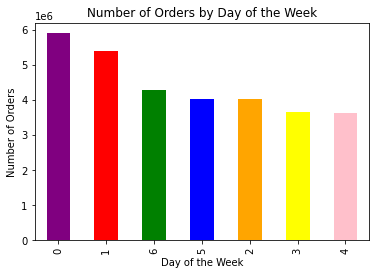

In [37]:
bar=full_data['orders_day_of_week'].value_counts().plot.bar(color=['purple','red','green','blue','orange','yellow','pink'])
# Adding title and labels
plt.title('Number of Orders by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')

In [38]:
bar.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_orders_dow.png'))

which departments have the highest frequency of product orders.

Text(0, 0.5, 'Number of Orders')

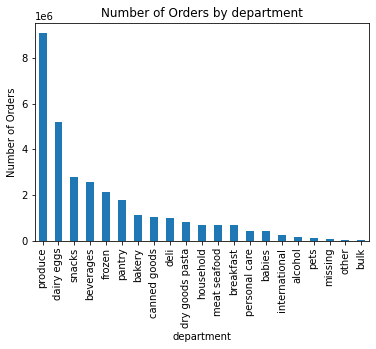

In [42]:
bar=full_data['department'].value_counts().plot.bar()
# Adding title and labels
plt.title('Number of Orders by department')
plt.xlabel('department')
plt.ylabel('Number of Orders')

In [43]:
bar.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_order_department.png'))

Ordering habits based on region

In [44]:
# Group by region and count unique customers
customers_per_region = full_data.groupby('Region')['user_id'].nunique()

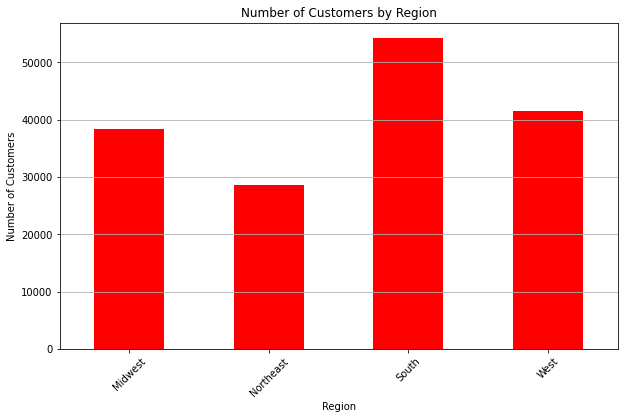

In [50]:
# Create the bar chart
plt.figure(figsize=(10, 6))
customers_per_region.plot(kind='bar', color='red')
plt.title('Number of Customers by Region')
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'no_of_customers_per_region.png'))
plt.show()

In [51]:
# Group by region and order number
customers_per_region = full_data.groupby('Region')['order_number'].nunique()

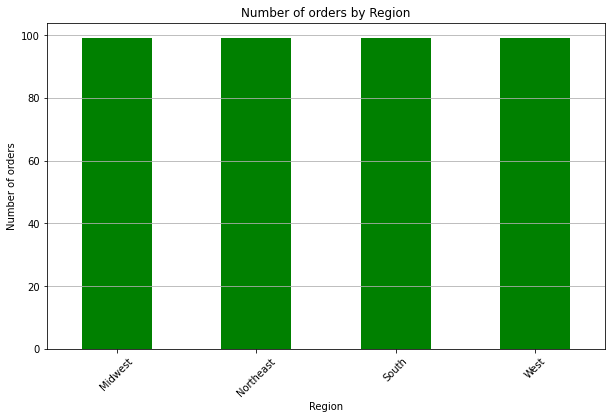

In [52]:
# Create the bar chart
plt.figure(figsize=(10, 6))
customers_per_region.plot(kind='bar', color='green')
plt.title('Number of orders by Region')
plt.xlabel('Region')
plt.ylabel('Number of orders')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'no_of_orders_per_region.png'))
plt.show()